# Import the libraries

In [1]:
import pandas as pd
import numpy as np
import geopy.distance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import lightgbm as lgb
from sklearn import preprocessing
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from tensorflow import keras

C:\Users\Enrico\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Enrico\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Enrico\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Define custom function

In [2]:
def encoding_categoricals(df=None):
    """
    Encodes dataframe categorical columns (transform categorical features into numerical features).

    :param pd.DataFrame data: dataframe to encode

    :returns: DataFrame with categorical columns encoded.
    :rtype: pd.DataFrame
    """
    encoders = []
    col_names = df.columns
    for col in col_names:
        if type(df[col].iloc[0]) == str:
            # Creating and fitting the encoder
            le = preprocessing.LabelEncoder()
            le.fit(df[col].astype(str))
            # Replace and storing data/encoder
            encoders.append(le)
            df.loc[:,col] = le.transform(df[col].astype(str))

    return df, encoders

In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
   Calculates great-circle distance between two points on a sphere given their longitudes and latitudes using the haversine formula.
    
   :param lat1: Fisrt point latitude
   :param lon1: First point longitude
   :param lat2: Second point latitude
   :param lon2: Second point longitude
    
   :returns: Great-circle distance between the two points in kilometres
    '''
    
    r = 6371 # Planet earth radius in kilometres
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

    return np.round(res, 2)

# Import data

In [4]:
#import geographic data of the city
geo = pd.read_excel("merged.xlsx","01.geo").set_index("geo_city")
#import seller data
seller = pd.read_excel("merged.xlsx", "03.sellers").set_index("seller_city")
#join seller and geo data
seller = geo.join(seller).reset_index()
#rename seller columns
seller.columns = ['seller_city', 'seller_geo_latitude', 'seller_geo_longitude', 'seller_geo_admin1_code',
                    'seller_geo_autonomous_community', 'seller_id', 'seller_autonomous_community']




In [5]:
#import customer
customer = pd.read_excel("merged.xlsx","02.customers").set_index("customer_city")
#join customer data
customer = geo.join(customer).reset_index()
#rename custmer columns
customer.columns = ['customer_city', 'customer_geo_latitude', 'customer_geo_longitude', 'customer_geo_admin1_code',
       'customer_geo_autonomous_community', 'customer_id', 'customer_unique_id',
       'customer_autonomous_community']




In [6]:
#import order 
order_items = pd.read_excel("merged.xlsx","05.order_items")
#import product
product_reviews = pd.read_excel("merged.xlsx","07.product_reviews")
#import order
order_status = pd.read_excel("merged.xlsx", "04.order_status")
#order payments
order_payments = pd.read_excel("merged.xlsx","06.order_payments")
#import product
product = pd.read_excel("merged.xlsx","08.products")

# Merge DF

In [7]:
#merge order items and product reviews
df = pd.merge(order_items, product_reviews, how="left", on=["order_id", "product_id"])
#merge df and seller
df = pd.merge(df, seller, how="left", on=["seller_id"])
#merge df and order_status
df = pd.merge(df, order_status, how="left", on=["order_id"])
#merge df and order_payments
df = pd.merge(df, order_payments, how="left", on=["order_id"])
#merge df and product
df = pd.merge(df, product, how="left", on=["product_id"])
#merge df and customer
df = pd.merge(df, customer, how="left", on=["customer_id"])


# Calculate the distance from seller to costumer

In [8]:
#delete na valuess
df = df.dropna()
#transform coordinate of seller
seller_coord = list(zip(df["seller_geo_latitude"],df["seller_geo_longitude"]))
#transform coordinate of customer
customer_coord = list(zip(df["customer_geo_latitude"],df["customer_geo_longitude"]))
#caluclate distance in km
df["distance_km"] = [haversine_distance(seller_coord[x][0],seller_coord[x][1], customer_coord[x][0],customer_coord[x][1]) for x in range(len(customer_coord))]
df.tail()


,order_id,order_item_sequence_id,product_id,price,shipping_cost,seller_id,max_shipping_seller_date,review_score,review_date,seller_city,...,product_width_cm,product_photo_quantity,customer_city,customer_geo_latitude,customer_geo_longitude,customer_geo_admin1_code,customer_geo_autonomous_community,customer_unique_id,customer_autonomous_community,distance_km
118137,1afe384f199748cff7a42c9902065560,1,4c2a4020fcd651812100ebbeac1b2753,59999,2918,610f72e407cdd7caaa2f8167b0163fd8,2019-09-14 02:09:00,5.0,2019-08-26 16:30:00,Madrid,...,55.0,2.0,Málaga,36.72016,-4.42034,51.0,Andalucía,24a438c52577c3c30ba86532b4166ff8,Andalucía,415.72
118138,7cfdf7265c9572fc7b7cbd3b9cc438b7,2,17e18b0c88a853dd6de3e48a7cfa9d9a,20,1925,cee48807215b30a12ca2ca10ffb5f250,2019-09-14 12:30:00,1.0,2019-08-29 14:16:00,Córdoba,...,11.0,1.0,Alcorcón,40.34582,-3.82487,29.0,Comunidad de Madrid,56b6eede1b10925212f054a7ba614796,Comunidad de Madrid,284.88
118139,3b61aab5de69abc1731138bd104a777f,1,6aa063e063f2ab982b471e58afe06d72,99999,2477,610f72e407cdd7caaa2f8167b0163fd8,2019-09-18 21:10:00,2.0,2019-09-02 22:51:00,Madrid,...,50.0,2.0,Madrid,40.41650,-3.70256,29.0,Comunidad de Madrid,101375bf617fd60c9eee42f98d9a73d6,Comunidad de Madrid,0.00
118142,c2bb89b5c1dd978d507284be78a04cb2,1,87b92e06b320e803d334ac23966c80b1,9999,6144,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:00,1.0,2018-06-12 13:24:00,Parla,...,25.0,5.0,Huelva,37.26638,-6.94004,51.0,Andalucía,44b6bbfea26596437062a38c8e6bcec1,Andalucía,429.73
118143,c2bb89b5c1dd978d507284be78a04cb2,2,87b92e06b320e803d334ac23966c80b1,9999,6144,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:00,1.0,2018-06-12 13:24:00,Parla,...,25.0,5.0,Huelva,37.26638,-6.94004,51.0,Andalucía,44b6bbfea26596437062a38c8e6bcec1,Andalucía,429.73


In [9]:
df.distance_km.describe().to_frame()

,distance_km
count,109438.000000
mean,403.225158
std,294.792202
min,0.000000
25%,223.490000
50%,383.870000
75%,523.740000
max,2284.220000


<AxesSubplot:xlabel='distance_km'>

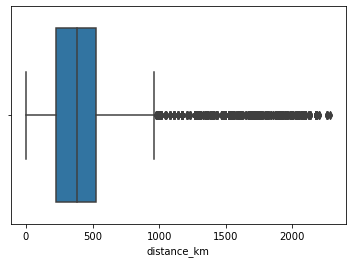

In [10]:
sns.boxplot(x=df["distance_km"])

# Time series analysis

Looks good. I will also add a column where the order date is expressed as ordinal format. This numerical format will simplify some of the processes later.


When it comes to delivery time, these values can be of interest:

Difference between estimated delivery date and true delivery date (shipping_time_delta)
Difference between order date and delivery date (shipping_duration)
Difference between order date and estimated delivery date (estimated_duration)
These columns will be created:

In [11]:
df.columns

Index(['order_id', 'order_item_sequence_id', 'product_id', 'price',
       'shipping_cost', 'seller_id', 'max_shipping_seller_date',
       'review_score', 'review_date', 'seller_city', 'seller_geo_latitude',
       'seller_geo_longitude', 'seller_geo_admin1_code',
       'seller_geo_autonomous_community', 'seller_autonomous_community',
       'customer_id', 'order_status', 'ts_order_purchase', 'ts_order_approved',
       'ts_order_delivered_carrier', 'ts_order_delivered_customer',
       'ts_order_estimated_delivery', 'payment_method',
       'payment_method_sequence_id', 'payment_installments_quantity',
       'transaction_value', 'product_category_name', 'product_weight_gr',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_photo_quantity', 'customer_city', 'customer_geo_latitude',
       'customer_geo_longitude', 'customer_geo_admin1_code',
       'customer_geo_autonomous_community', 'customer_unique_id',
       'customer_autonomous_community', 'd

In [12]:
#time features 
df_time_series = df
#Difference between estimated delivery date and true delivery date (shipping_time_delta)
df_time_series["delta_true_predicted"] = abs((df_time_series["ts_order_estimated_delivery"]-df_time_series["ts_order_delivered_customer"]).dt.days)
#Difference between order date and delivery date (shipping_duration)
#df_time_series["day_deliver"] = (df_time_series["ts_order_delivered_customer"]-df_time_series["ts_order_purchase"]).dt.days
df_time_series["day_deliver"] = (df_time_series["ts_order_delivered_customer"]-df_time_series["ts_order_approved"]).dt.days
#Difference between order date and estimated delivery date (estimated_duration)
df_time_series["estimated_day_deliver"] = (df_time_series["ts_order_estimated_delivery"]-df_time_series["ts_order_purchase"]).dt.days
# Difference between purchased and approved
df_time_series['approved - purchase'] = (df_time_series["ts_order_approved"]-df_time_series["ts_order_purchase"]).dt.days
#difference between max shipping date and purchase
df_time_series['max_shipping_seller_date - purchase'] = (df_time_series["max_shipping_seller_date"]-df_time_series["ts_order_purchase"]).dt.days
#difference between delivered carrier and purchase
df_time_series['ts_order_delivered_carrier - purchase'] = (df_time_series["ts_order_delivered_carrier"]-df_time_series["ts_order_purchase"]).dt.days


<AxesSubplot:xlabel='ts_order_delivered_carrier - purchase'>

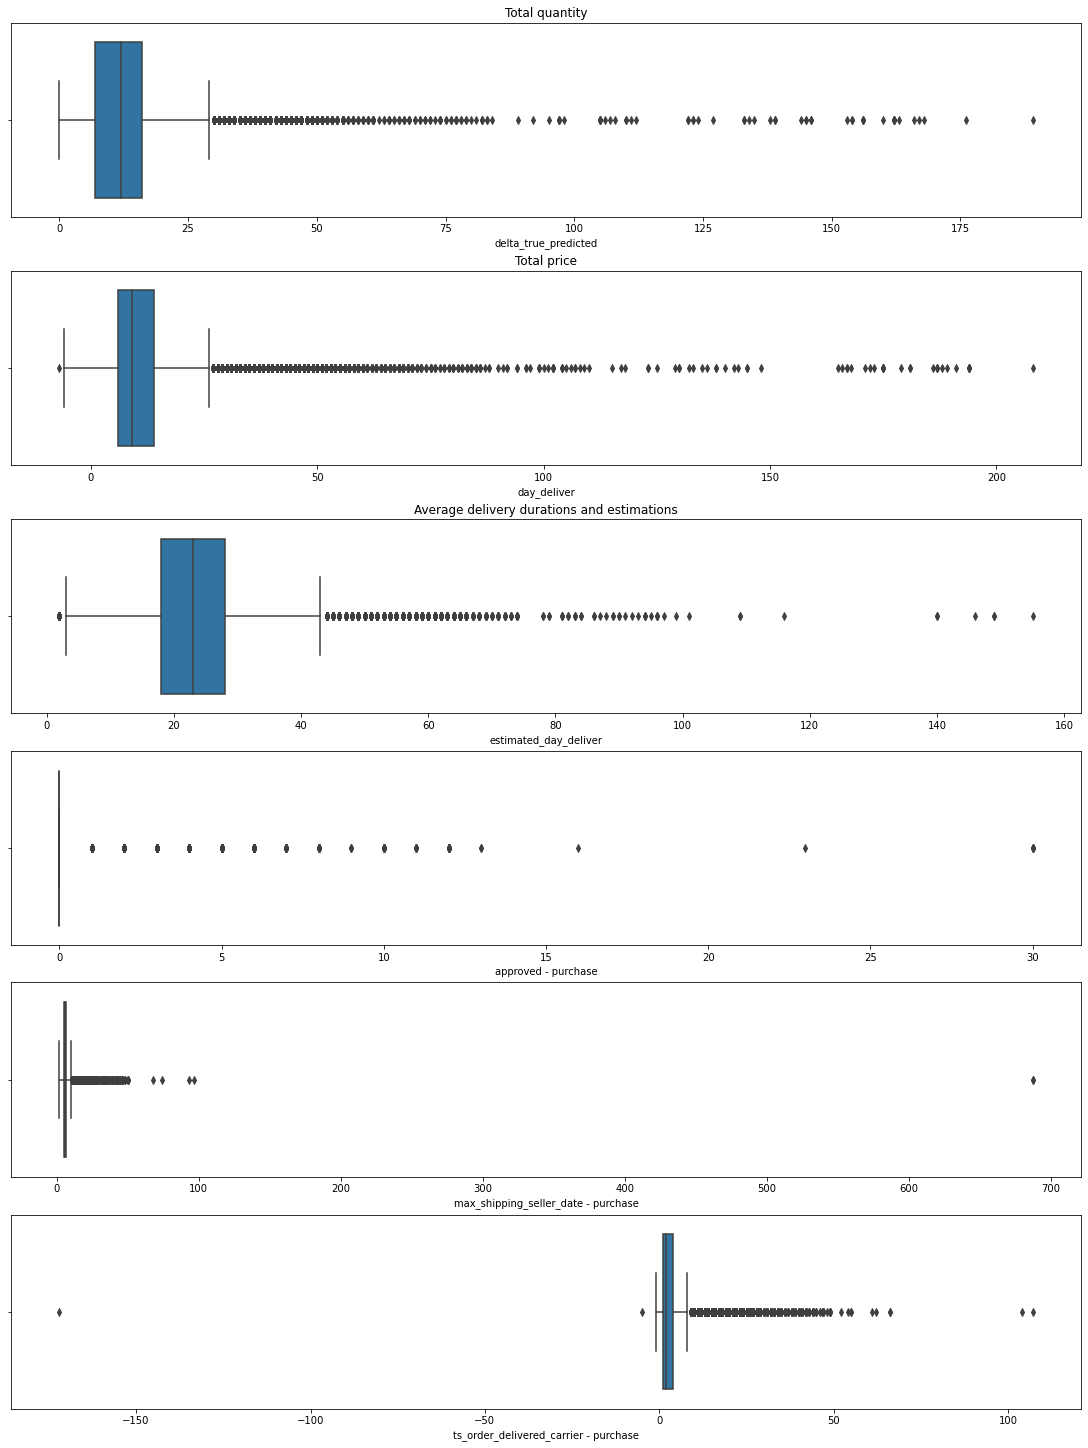

In [13]:
#plot the boxplot of variables above calculated
fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(6, 1, figsize = (15, 20),constrained_layout=True,)
ax1.set_title('Total quantity')
ax2.set_title('Total price')
ax3.set_title('Average delivery durations and estimations')

sns.boxplot(
            data = df_time_series,
            x = df_time_series['delta_true_predicted'],
            ax = ax1
            )

sns.boxplot(
            data = df_time_series,
            x = df_time_series['day_deliver'],
            ax = ax2
            )

sns.boxplot(
            data = df_time_series,
            x = df_time_series['estimated_day_deliver'],
            ax = ax3
            )
sns.boxplot(
            data = df_time_series,
            x = df_time_series['approved - purchase'],
            ax = ax4
            )
sns.boxplot(
            data = df_time_series,
            x = df_time_series['max_shipping_seller_date - purchase'],
            ax = ax5
            )
sns.boxplot(
            data = df_time_series,
            x = df_time_series['ts_order_delivered_carrier - purchase'],
            ax = ax6
            )




# Daily feature extraction 

In [14]:
#copy the dg
df_daily = df_time_series.reset_index(drop=True)
#find the day and moth 
day = [str(df_daily["ts_order_purchase"][x])[5:10] for x in range(len(df_daily))]
#attach to df
df_daily["ts_order_purchase"] = day

In [15]:
#define parameters to groupby
parameters = { 
        'order_item_sequence_id':'sum',
        'price':'sum',
       'shipping_cost':'sum', 
       'review_score':'mean',
       'transaction_value':'sum', 
        'product_weight_gr':'sum',
       'product_length_cm':'sum', 
        'product_height_cm':'sum', 
        'product_width_cm':'sum',
        'customer_unique_id':'count',
        'distance_km':'mean',
        'delta_true_predicted':'mean',
       'day_deliver':'mean', 
        'estimated_day_deliver':'mean', 
        'approved - purchase':'mean',
       'max_shipping_seller_date - purchase':'mean',
       'ts_order_delivered_carrier - purchase':'mean'
}

In [16]:
#groupby with above metioned parameters, and calculate the variables
df_daily = df_daily.groupby(by = ['ts_order_purchase'], as_index=False).agg(parameters)
#calculate mean day deliver
df_daily["day_mean_delivery"] = df_daily["day_deliver"].round(0)
df_daily.tail()

,ts_order_purchase,order_item_sequence_id,price,shipping_cost,review_score,transaction_value,product_weight_gr,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,distance_km,delta_true_predicted,day_deliver,estimated_day_deliver,approved - purchase,max_shipping_seller_date - purchase,ts_order_delivered_carrier - purchase,day_mean_delivery
360,12-27,193,316961,240276,3.988304,1632968.0,284351.0,4857.0,2567.0,3757.0,171,424.544503,15.087719,12.713450,28.298246,0.157895,7.649123,2.812865,13.0
361,12-28,164,415598,228292,4.213333,1424759.0,258380.0,4228.0,2363.0,3404.0,150,361.052333,15.306667,13.780000,28.180000,0.020000,7.346667,4.046667,14.0
362,12-29,192,365092,253918,4.162500,1783543.0,299213.0,4907.0,2693.0,3657.0,160,378.775000,14.456250,13.337500,28.412500,0.531250,7.818750,4.681250,13.0
363,12-30,113,434937,163015,4.220000,1213672.0,246870.0,2985.0,2026.0,2355.0,100,408.170000,14.350000,13.720000,28.690000,0.610000,7.130000,4.810000,14.0
364,12-31,73,305874,115465,4.239437,686937.0,164512.0,1985.0,1206.0,1592.0,71,374.045775,15.000000,12.422535,27.126761,0.352113,6.098592,3.563380,12.0


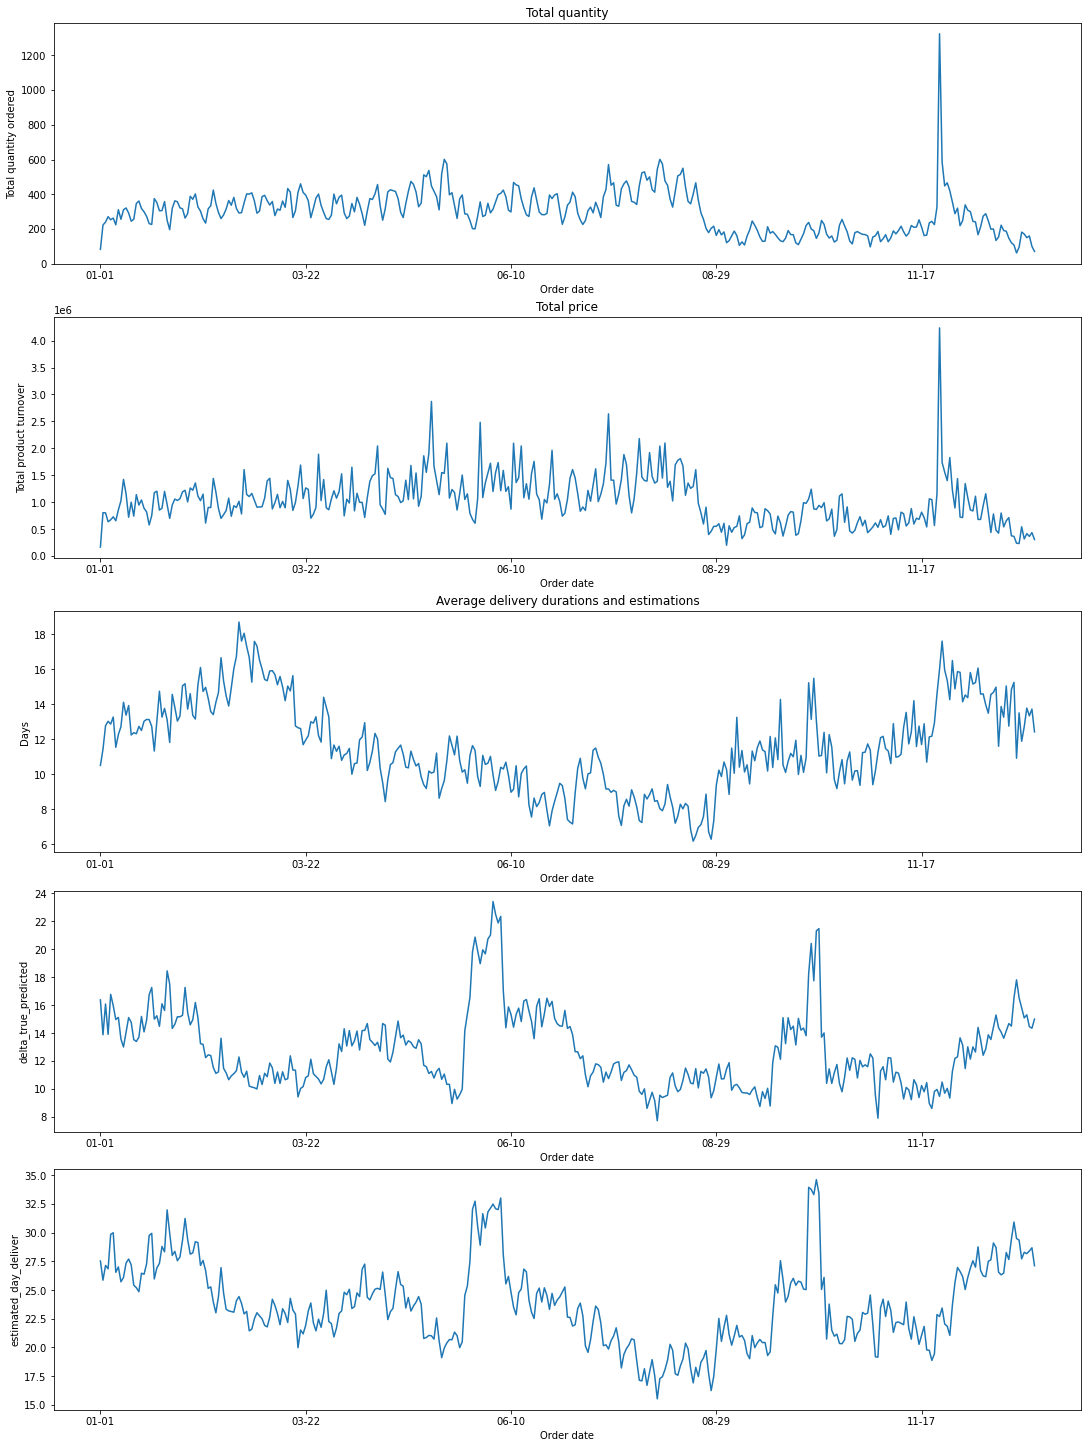

In [17]:
#plot above calculated variables
fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(5, 1, figsize = (15, 20),constrained_layout=True,)
ax1.set_title('Total quantity')
ax2.set_title('Total price')
ax3.set_title('Average delivery durations and estimations')

sns.lineplot(
            data = df_daily,
            x = 'ts_order_purchase',
            y ='customer_unique_id',
            ax = ax1
            )

sns.lineplot(
            data = df_daily,
            x = 'ts_order_purchase',
            y = 'price',
            ax = ax2
            )

sns.lineplot(
            data = df_daily,
            x = 'ts_order_purchase',
            y = 'day_deliver',
            ax = ax3
            )
sns.lineplot(
            data = df_daily,
            x = 'ts_order_purchase',
            y = 'delta_true_predicted',
            ax = ax4
            )
sns.lineplot(
            data = df_daily,
            x = 'ts_order_purchase',
            y = 'estimated_day_deliver',
            ax = ax5
            )

ax1.set(xlabel = 'Order date', ylabel = 'Total quantity ordered')
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
ax2.set(xlabel = 'Order date', ylabel = 'Total product turnover')
ax2.xaxis.set_major_locator(plt.MaxNLocator(6))
ax3.set(xlabel = 'Order date', ylabel = 'Days')
ax3.xaxis.set_major_locator(plt.MaxNLocator(6))
ax4.set(xlabel = 'Order date', ylabel = 'delta_true_predicted')
ax4.xaxis.set_major_locator(plt.MaxNLocator(6))
ax5.set(xlabel = 'Order date', ylabel = 'estimated_day_deliver')
ax5.xaxis.set_major_locator(plt.MaxNLocator(6))


# Add the daily feature to the datatset

In [18]:
#copy df time series in order to add daily features
df_shipping = df_time_series.dropna()
#select only delivered order
df_shipping = df_shipping[df_shipping["order_status"]=="delivered"].reset_index(drop=True)


In [19]:
#rename columns
df_daily.columns = ['mean_ts_order_purchase', 
                    'mean_order_item_sequence_id',
                    'mean_price',
                    'mean_shipping_cost',
                    'mean_review_score',
                    'mean_transaction_value', 
                    'mean_product_weight_gr',
                    'mean_product_length_cm', 
                    'mean_product_height_cm',
                    'mean_product_width_cm',
                    'mean_customer_unique_id', 
                    'mean_distance_km', 
                    'mean_delta_true_predicted',
                    'mean_day_deliver',
                    'mean_estimated_day_deliver', 
                    'mean_approved - purchase',
                    'mean_max_shipping_seller_date - purchase',
                    'mean_ts_order_delivered_carrier - purchase',
                    'mean_day_mean_delivery']
#select columns
df_daily = df_daily[["mean_ts_order_purchase",
                     "mean_order_item_sequence_id",
                     "mean_price",
                     "mean_shipping_cost",
                     "mean_product_weight_gr",
                     "mean_customer_unique_id",
                     "mean_delta_true_predicted",
                     "mean_day_deliver",
                     "mean_estimated_day_deliver"]].set_index("mean_ts_order_purchase")

In [20]:
#join df daily with df shipping
day = [str(df_shipping["ts_order_purchase"][x])[5:10] for x in range(len(df_shipping))]
df_shipping["day_index"] = day
df_shipping = df_shipping.set_index("day_index")
df_shipping = df_shipping.join(df_daily)
df_shipping


,order_id,order_item_sequence_id,product_id,price,shipping_cost,seller_id,max_shipping_seller_date,review_score,review_date,seller_city,...,max_shipping_seller_date - purchase,ts_order_delivered_carrier - purchase,mean_order_item_sequence_id,mean_price,mean_shipping_cost,mean_product_weight_gr,mean_customer_unique_id,mean_delta_true_predicted,mean_day_deliver,mean_estimated_day_deliver
01-01,4f6daad34df49e10c8072b33faafcb2a,1,468a4d241243dd96169888c0ad022086,148,3636,e067ad2c1c0b48758eb1b5228bcf7a68,2019-01-05 02:58:00,5.0,2019-01-31 22:13:00,Almería,...,4,4,96,166269,120358,107868.0,83,16.373494,10.506024,27.542169
01-01,67a98eaf984ba84c596f9f5456634f20,1,c4baedd846ed09b85f78a781b522f126,139,5084,a1043bafd471dff536d0c462352beb48,2019-01-05 09:46:00,4.0,2019-01-13 18:55:00,Parla,...,4,1,96,166269,120358,107868.0,83,16.373494,10.506024,27.542169
01-01,3fdebcfe1a2cdcd4ee2770a2e28b2af4,1,9b2a0b97c2471793b067f77f2252defa,899,1318,8f2ce03f928b567e3d56181ae20ae952,2019-01-05 11:06:00,4.0,2019-01-11 23:17:00,Jaén,...,4,2,96,166269,120358,107868.0,83,16.373494,10.506024,27.542169
01-01,7c40601f78201a5c1fd06535bec6a480,1,ef1c671d636510846d72e7aa3af1e0a5,2399,1185,ea8482cd71df3c1969d7b9473ff13abc,2019-01-05 11:06:00,5.0,2019-01-14 10:16:00,Madrid,...,4,4,96,166269,120358,107868.0,83,16.373494,10.506024,27.542169
01-01,559115c14f48d999adcc027b4a702c8b,1,5403528d987ad26e8d7cb25940411987,49,778,6560211a19b47992c3666cc44a7e94c0,2019-01-05 11:10:00,3.0,2019-01-09 22:31:00,Madrid,...,4,1,96,166269,120358,107868.0,83,16.373494,10.506024,27.542169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-31,1c31ab2a0da17fb7deea7714eb37847e,1,2028bf1b01cafb2d2b1901fca4083222,5699,1584,cc419e0650a3c5ba77189a1882b7556a,2019-01-10 01:30:00,5.0,2019-01-15 01:27:00,Córdoba,...,10,3,73,305874,115465,164512.0,71,15.000000,12.422535,27.126761
12-31,35298b52820bdcc64b7bf71ccc28a36c,1,f731f8587d4088c174397e010cf892a9,5699,2568,cc419e0650a3c5ba77189a1882b7556a,2019-01-10 19:46:00,5.0,2019-01-15 21:41:00,Córdoba,...,10,2,73,305874,115465,164512.0,71,15.000000,12.422535,27.126761
12-31,67125a02929ae733f8087641f22c6842,1,480be8d20c4b6a7df1eae0f2c17f2db2,34,827,41c2bad7229b0c25e6becf179ebf63ff,2019-01-11 04:16:00,5.0,2019-01-05 22:28:00,Gerona,...,10,3,73,305874,115465,164512.0,71,15.000000,12.422535,27.126761
12-31,0c355e13567802628373895daf5f0a61,1,b425f28bf3d41f70cc18da7a525ee65c,425,1248,a425f92c199eb576938df686728acd20,2019-01-11 20:27:00,5.0,2019-01-16 20:52:00,Coruña,...,11,10,73,305874,115465,164512.0,71,15.000000,12.422535,27.126761


# Cities feature extraction 

In [21]:
#copy df shipping in order to calculate cities varibles
df_cities = df_shipping.reset_index(drop=True)
#define parameters to groupby variables
parameters = { 
                'distance_km':'mean',
                'delta_true_predicted':'mean',
                'day_deliver':'mean', 
                'estimated_day_deliver':'mean', 
                'approved - purchase':'mean',
                'max_shipping_seller_date - purchase':'mean',
                'ts_order_delivered_carrier - purchase':'mean'
            }
df_cities = df_cities.groupby(by = ['seller_city']).agg(parameters)
df_cities['city_estimated_time_error'] = abs(
    pd.to_numeric(df_cities['day_deliver'], downcast='float') 
  - pd.to_numeric(df_cities['estimated_day_deliver'], downcast='float')
)/pd.to_numeric(df_cities['estimated_day_deliver'], downcast='float')
df_cities

,distance_km,delta_true_predicted,day_deliver,estimated_day_deliver,approved - purchase,max_shipping_seller_date - purchase,ts_order_delivered_carrier - purchase,city_estimated_time_error
seller_city,,,,,,,,
Albacete,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610,0.542215
Alcalá de Henares,302.900246,12.530756,12.267135,23.481547,0.237258,6.084359,2.606327,0.477584
Alcobendas,273.767162,19.026403,14.250825,33.019802,0.382838,8.501650,4.072607,0.568416
Alcorcón,279.636747,14.301282,10.076923,24.057692,0.274038,5.676282,2.160256,0.581135
Alicante,395.683415,15.524554,10.640625,26.363839,0.301339,6.535714,3.290179,0.596393
...,...,...,...,...,...,...,...,...
Valladolid,380.103766,13.483961,12.829847,26.138075,0.323570,5.702929,2.181311,0.509151
Vitoria,351.230000,14.000000,11.000000,26.000000,0.000000,6.000000,0.000000,0.576923
Zamora,383.123314,15.020173,11.345821,25.685879,0.268012,5.573487,1.279539,0.558286


[Text(0, 0, 'Cáceres'),
 Text(1, 0, 'Manacor - Mallorca'),
 Text(2, 0, 'Ávila'),
 Text(3, 0, 'Pamplona'),
 Text(4, 0, 'Oviedo')]

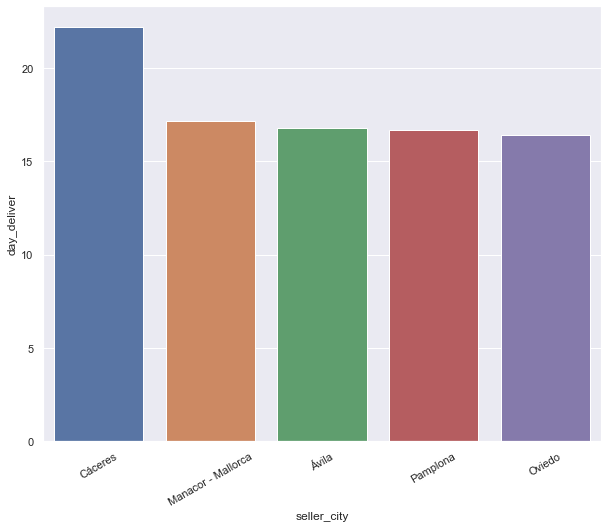

In [22]:
#print cities variables
sns.set(rc={'figure.figsize':(10,8)})
city_ana = df_cities.sort_values('day_deliver', ascending=False)[0:5].reset_index()
ax = sns.barplot(x="seller_city", y="day_deliver", data=city_ana)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

[Text(0, 0, 'Oviedo'),
 Text(1, 0, 'Ávila'),
 Text(2, 0, 'Alcobendas'),
 Text(3, 0, 'Logroño'),
 Text(4, 0, 'Calahorra')]

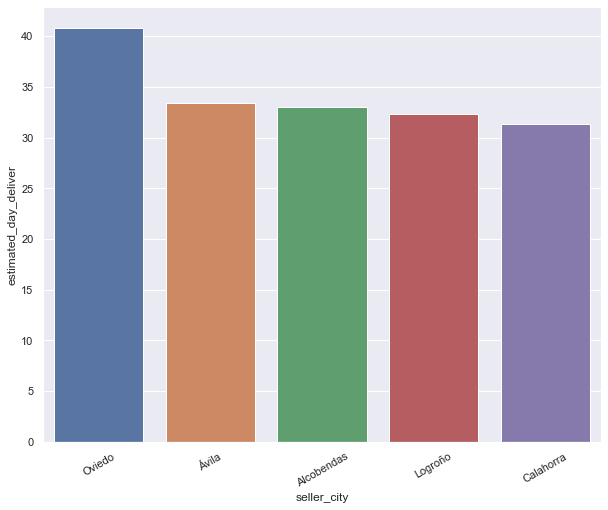

In [23]:
city_ana = df_cities.sort_values('estimated_day_deliver', ascending=False)[0:5].reset_index()
ax = sns.barplot(x="seller_city", y="estimated_day_deliver", data=city_ana)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

[Text(0, 0, 'Oviedo'),
 Text(1, 0, 'Calahorra'),
 Text(2, 0, 'Puerto del Rosario - Fuerteventura'),
 Text(3, 0, 'Cuenca'),
 Text(4, 0, 'Alcobendas')]

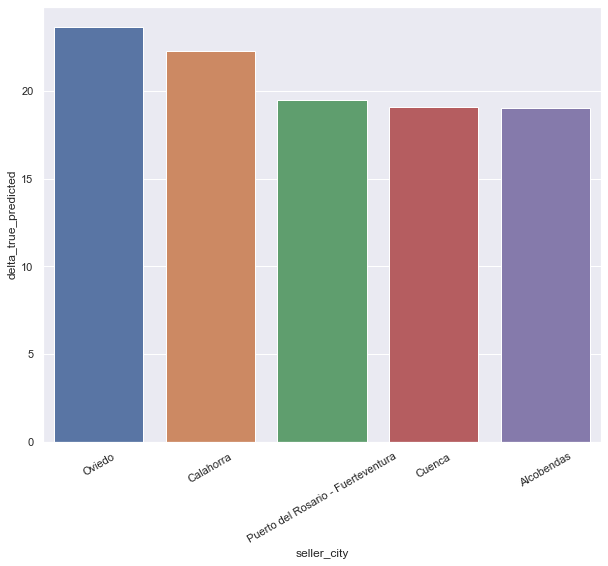

In [24]:
city_ana = df_cities.sort_values('delta_true_predicted', ascending=False)[0:5].reset_index()
ax = sns.barplot(x="seller_city", y="delta_true_predicted", data=city_ana)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

[Text(0, 0, 'Las Palmas de Gran Canaria'),
 Text(1, 0, 'Puerto del Rosario - Fuerteventura'),
 Text(2, 0, 'Manacor - Mallorca'),
 Text(3, 0, 'Coruña'),
 Text(4, 0, 'Pontevedra')]

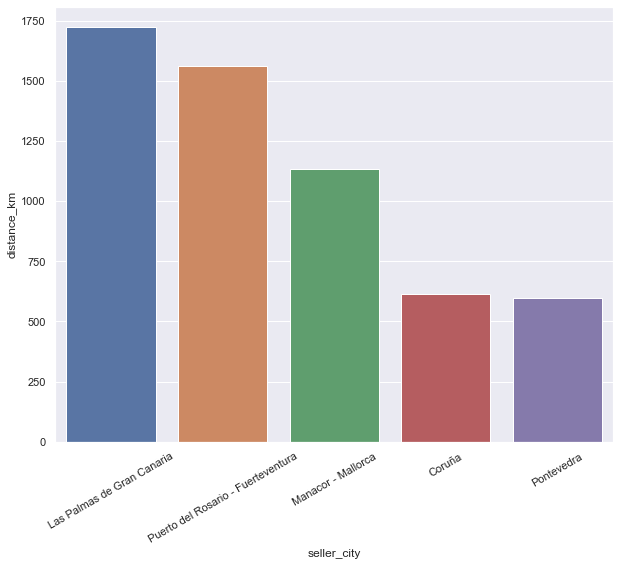

In [25]:
city_ana = df_cities.sort_values('distance_km', ascending=False)[0:5].reset_index()
ax = sns.barplot(x="seller_city", y="distance_km", data=city_ana)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

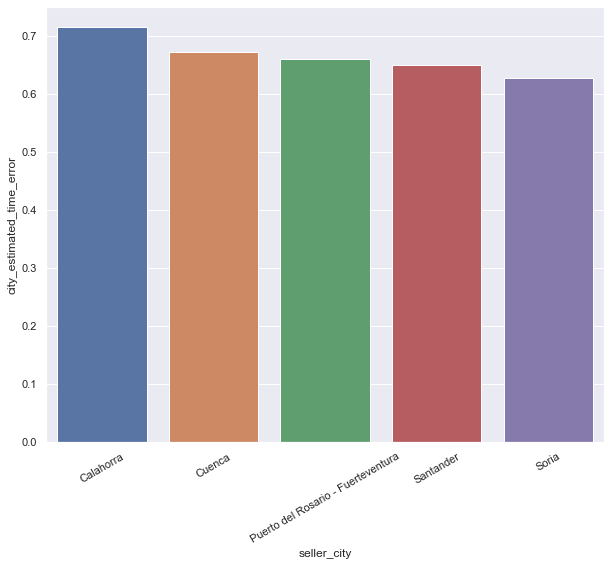

In [26]:
city_ana = df_cities.sort_values('city_estimated_time_error', ascending=False)[0:5].reset_index()
ax = sns.barplot(x="seller_city", y="city_estimated_time_error", data=city_ana)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

df_cities = df_cities.drop(columns=["city_estimated_time_error"])


# Add cities variable to df

In [27]:
#join variables
df_cities.columns = ['city_distance_km',
                    'city_delta_true_predicted',
                    'city_day_deliver',
                    'city_estimated_day_deliver',
                    'city_approved - purchase',
                    'city_max_shipping_seller_date - purchase',
                    'city_ts_order_delivered_carrier - purchase']

df_shipping = df_shipping.set_index("seller_city")
df_shipping = df_shipping.join(df_cities)
df_shipping = df_shipping.reset_index()
df_shipping

,seller_city,order_id,order_item_sequence_id,product_id,price,shipping_cost,seller_id,max_shipping_seller_date,review_score,review_date,...,mean_delta_true_predicted,mean_day_deliver,mean_estimated_day_deliver,city_distance_km,city_delta_true_predicted,city_day_deliver,city_estimated_day_deliver,city_approved - purchase,city_max_shipping_seller_date - purchase,city_ts_order_delivered_carrier - purchase
0,Albacete,40f5d5356396abbec18c0c893d329422,1,547b95702aec86f05ac37e61d164891c,129,382,001cca7ae9ae17fb1caed9dfb1094831,2019-01-05 21:06:00,2.0,2019-02-03 12:30:00,...,16.373494,10.506024,27.542169,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610
1,Albacete,c1f3674061e410426560d52e7bf096c3,1,732b161706d966d09976eec245d8b3bf,649,1994,f3295428338a40977a03f555246a70f4,2019-01-16 11:28:00,5.0,2019-01-24 10:55:00,...,13.009646,14.112540,26.106109,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610
2,Albacete,3363e330c754a732795f39079bb76d55,1,08574b074924071f4e201e151b152b4e,99,4599,001cca7ae9ae17fb1caed9dfb1094831,2019-01-16 12:17:00,3.0,2019-01-29 14:50:00,...,13.009646,14.112540,26.106109,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610
3,Albacete,2f382dc90733d9d7e7db788f9a954fbe,1,08574b074924071f4e201e151b152b4e,99,4599,001cca7ae9ae17fb1caed9dfb1094831,2019-01-18 14:08:00,5.0,2019-01-27 13:46:00,...,15.109589,13.924658,27.708904,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610
4,Albacete,2da52e987f62fa65e50c6fd5dd8994d1,1,08574b074924071f4e201e151b152b4e,99,3308,001cca7ae9ae17fb1caed9dfb1094831,2019-01-19 13:49:00,5.0,2019-01-25 10:58:00,...,13.400576,12.314121,25.210375,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109426,Ávila,7ed504f74d87e1d685166f9fcc73eeeb,1,fb0e979620b2fd991a12edd108fc83f3,310,1861,7178f9f4dd81dcef02f62acdf8151e01,2018-12-28 13:29:00,2.0,2019-01-09 23:56:00,...,14.165775,15.042781,28.283422,339.224941,18.544118,16.797059,33.376471,0.435294,10.685294,5.235294
109427,Ávila,aa078289a37e7fc6858559006061646d,1,1dec4c88c685d5a07bf01dcb0f8bf9f8,559,4143,712e6ed8aa4aa1fa65dab41fed5737e4,2019-01-04 14:30:00,1.0,2019-02-09 00:01:00,...,14.680272,12.748299,27.666667,339.224941,18.544118,16.797059,33.376471,0.435294,10.685294,5.235294
109428,Ávila,e3254323dd511d109978d37345cdcbae,1,1dec4c88c685d5a07bf01dcb0f8bf9f8,659,4213,712e6ed8aa4aa1fa65dab41fed5737e4,2019-01-04 19:30:00,4.0,2019-02-06 17:45:00,...,16.509259,15.250000,30.935185,339.224941,18.544118,16.797059,33.376471,0.435294,10.685294,5.235294
109429,Ávila,43e16679b4c9df0ae3d5fefa59a34ff4,1,d070415dddac66bcbc0a2e4f253c0f81,315,11606,712e6ed8aa4aa1fa65dab41fed5737e4,2019-01-02 16:08:00,4.0,2019-01-09 08:25:00,...,17.806452,10.919355,29.500000,339.224941,18.544118,16.797059,33.376471,0.435294,10.685294,5.235294


# Estimated Time error

In [28]:
df_shipping['estimated_time_error'] = (
    pd.to_numeric(df_shipping['day_deliver'], downcast='float') 
  - pd.to_numeric(df_shipping['estimated_day_deliver'], downcast='float')
)/pd.to_numeric(df_shipping['estimated_day_deliver'], downcast='float')

df_shipping['city_estimated_time_error'] = (
    pd.to_numeric(df_shipping['city_day_deliver'], downcast='float') 
  - pd.to_numeric(df_shipping['city_estimated_day_deliver'], downcast='float')
)/pd.to_numeric(df_shipping['city_estimated_day_deliver'], downcast='float')

df_shipping['mean_estimated_time_error'] = (
    pd.to_numeric(df_shipping['mean_day_deliver'], downcast='float') 
  - pd.to_numeric(df_shipping['mean_estimated_day_deliver'], downcast='float')
)/pd.to_numeric(df_shipping['mean_estimated_day_deliver'], downcast='float')

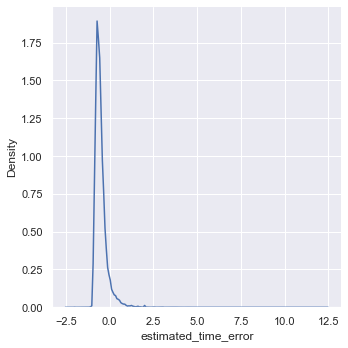

In [29]:
sns.displot(df_shipping, x="estimated_time_error", kind="kde", bw_adjust=.25)

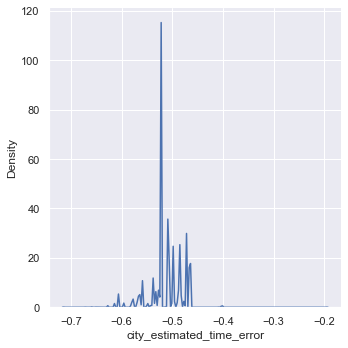

In [30]:
sns.displot(df_shipping, x="city_estimated_time_error", kind="kde", bw_adjust=.25)

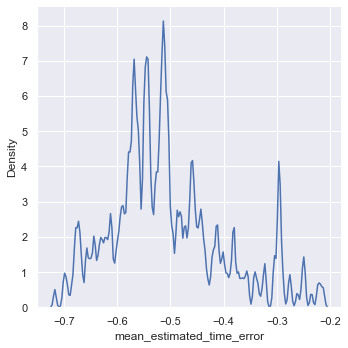

In [31]:
sns.displot(df_shipping, x="mean_estimated_time_error", kind="kde", bw_adjust=.25)

# Data preparation for models

In [32]:
df_stored = df_shipping

In [33]:
#select columns
df_shipping = df_stored[["price",
                        'shipping_cost', 
                        "seller_id",
                        "customer_id",
                        "seller_city",
                        'customer_city',
                        'transaction_value',
                        'product_weight_gr',
                        'product_length_cm', 
                        'product_height_cm',
                        'product_width_cm',
                        'distance_km', 
                        'day_deliver',
                        'estimated_day_deliver',
                        'approved - purchase',
                        'city_distance_km',
                        'city_delta_true_predicted',
                        'city_day_deliver',
                        'city_estimated_day_deliver',
                        'city_approved - purchase',
                        'city_max_shipping_seller_date - purchase',
                        'city_ts_order_delivered_carrier - purchase',
                        'max_shipping_seller_date - purchase',
                        "mean_order_item_sequence_id",
                        "mean_price",
                        "mean_shipping_cost",
                        "mean_product_weight_gr",
                        "mean_customer_unique_id",
                        "mean_delta_true_predicted",
                        "mean_day_deliver",
                        "mean_estimated_day_deliver",
                        "city_estimated_time_error",
                        "mean_estimated_time_error",
                         "delta_true_predicted"
                        ]]

df_shipping = df_shipping.reset_index(drop=True)
df_shipping, encoders = encoding_categoricals(df_shipping)
df_shipping.tail()

,price,shipping_cost,seller_id,customer_id,seller_city,customer_city,transaction_value,product_weight_gr,product_length_cm,product_height_cm,...,mean_price,mean_shipping_cost,mean_product_weight_gr,mean_customer_unique_id,mean_delta_true_predicted,mean_day_deliver,mean_estimated_day_deliver,city_estimated_time_error,mean_estimated_time_error,delta_true_predicted
109426,310,1861,1296,59394,60,2,32861.0,550.0,16.0,16.0,...,655269,313141,381548.0,187,14.165775,15.042781,28.283422,-0.49674,-0.468141,20
109427,559,4143,1287,87402,60,60,60043.0,17600.0,49.0,49.0,...,713182,239070,361818.0,147,14.680272,12.748299,27.666667,-0.49674,-0.539218,7
109428,659,4213,1287,54744,60,9,70113.0,17600.0,49.0,49.0,...,365292,187872,243369.0,108,16.509259,15.250000,30.935185,-0.49674,-0.507034,20
109429,315,11606,1287,39148,60,21,4316.0,20100.0,61.0,61.0,...,238293,84006,88861.0,62,17.806452,10.919355,29.500000,-0.49674,-0.629852,32
109430,252,4379,2587,17757,60,45,29579.0,350.0,25.0,12.0,...,365092,253918,299213.0,160,14.456250,13.337500,28.412500,-0.49674,-0.530576,46


<AxesSubplot:>

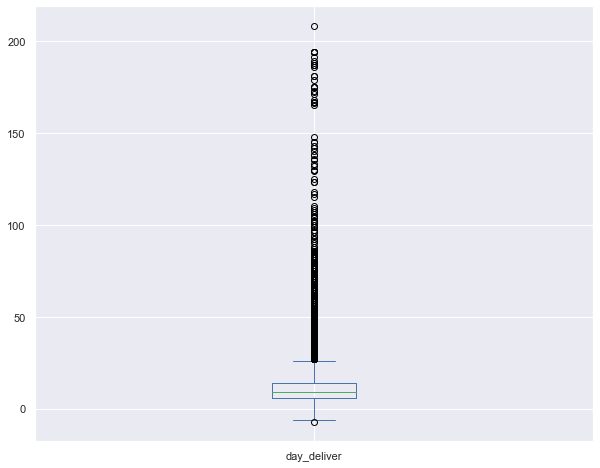

In [34]:
#print boxplot
df_shipping["day_deliver"].plot.box()

In [35]:
df_shipping

,price,shipping_cost,seller_id,customer_id,seller_city,customer_city,transaction_value,product_weight_gr,product_length_cm,product_height_cm,...,mean_price,mean_shipping_cost,mean_product_weight_gr,mean_customer_unique_id,mean_delta_true_predicted,mean_day_deliver,mean_estimated_day_deliver,city_estimated_time_error,mean_estimated_time_error,delta_true_predicted
0,129,382,1,13302,0,4,1672.0,9100.0,42.0,13.0,...,166269,120358,107868.0,83,16.373494,10.506024,27.542169,-0.542215,-0.618548,2
1,649,1994,2719,6279,0,35,8484.0,2100.0,30.0,17.0,...,1423063,508294,725690.0,311,13.009646,14.112540,26.106109,-0.542215,-0.459416,10
2,99,4599,1,12706,0,62,14499.0,9000.0,42.0,12.0,...,1423063,508294,725690.0,311,13.009646,14.112540,26.106109,-0.542215,-0.459416,12
3,99,4599,1,81242,0,10,14499.0,9000.0,42.0,12.0,...,720294,524338,660455.0,292,15.109589,13.924658,27.708904,-0.542215,-0.497466,19
4,99,3308,1,43083,0,54,1328.0,9000.0,42.0,12.0,...,1139801,580027,759126.0,347,13.400576,12.314121,25.210375,-0.542215,-0.511545,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109426,310,1861,1296,59394,60,2,32861.0,550.0,16.0,16.0,...,655269,313141,381548.0,187,14.165775,15.042781,28.283422,-0.496740,-0.468141,20
109427,559,4143,1287,87402,60,60,60043.0,17600.0,49.0,49.0,...,713182,239070,361818.0,147,14.680272,12.748299,27.666667,-0.496740,-0.539218,7
109428,659,4213,1287,54744,60,9,70113.0,17600.0,49.0,49.0,...,365292,187872,243369.0,108,16.509259,15.250000,30.935185,-0.496740,-0.507034,20
109429,315,11606,1287,39148,60,21,4316.0,20100.0,61.0,61.0,...,238293,84006,88861.0,62,17.806452,10.919355,29.500000,-0.496740,-0.629852,32


In [36]:
#remove ouliers
df_shipping = df_shipping[df_shipping["day_deliver"]>0]
df_shipping = df_shipping[df_shipping["day_deliver"]<10]

<AxesSubplot:>

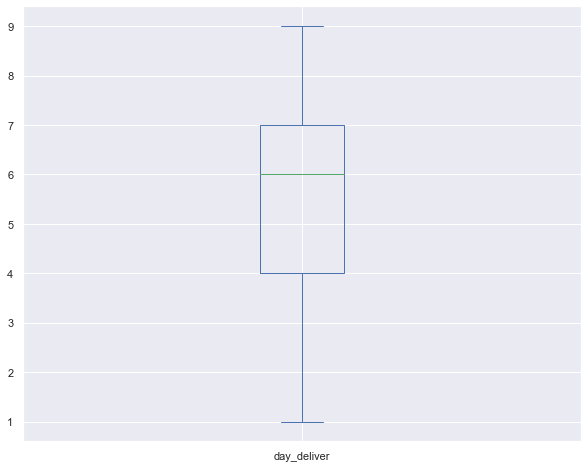

In [37]:
#print boxplot
df_shipping["day_deliver"].plot.box()

In [38]:
#store error in otrder to compare
estimated_error = df_shipping.delta_true_predicted.mean()
estimated_error

13.538435519475895

In [39]:
df_stored

,seller_city,order_id,order_item_sequence_id,product_id,price,shipping_cost,seller_id,max_shipping_seller_date,review_score,review_date,...,city_distance_km,city_delta_true_predicted,city_day_deliver,city_estimated_day_deliver,city_approved - purchase,city_max_shipping_seller_date - purchase,city_ts_order_delivered_carrier - purchase,estimated_time_error,city_estimated_time_error,mean_estimated_time_error
0,Albacete,40f5d5356396abbec18c0c893d329422,1,547b95702aec86f05ac37e61d164891c,129,382,001cca7ae9ae17fb1caed9dfb1094831,2019-01-05 21:06:00,2.0,2019-02-03 12:30:00,...,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610,0.033333,-0.542215,-0.618548
1,Albacete,c1f3674061e410426560d52e7bf096c3,1,732b161706d966d09976eec245d8b3bf,649,1994,f3295428338a40977a03f555246a70f4,2019-01-16 11:28:00,5.0,2019-01-24 10:55:00,...,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610,-0.454545,-0.542215,-0.459416
2,Albacete,3363e330c754a732795f39079bb76d55,1,08574b074924071f4e201e151b152b4e,99,4599,001cca7ae9ae17fb1caed9dfb1094831,2019-01-16 12:17:00,3.0,2019-01-29 14:50:00,...,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610,-0.428571,-0.542215,-0.459416
3,Albacete,2f382dc90733d9d7e7db788f9a954fbe,1,08574b074924071f4e201e151b152b4e,99,4599,001cca7ae9ae17fb1caed9dfb1094831,2019-01-18 14:08:00,5.0,2019-01-27 13:46:00,...,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610,-0.703704,-0.542215,-0.497466
4,Albacete,2da52e987f62fa65e50c6fd5dd8994d1,1,08574b074924071f4e201e151b152b4e,99,3308,001cca7ae9ae17fb1caed9dfb1094831,2019-01-19 13:49:00,5.0,2019-01-25 10:58:00,...,363.449675,13.574007,11.548736,25.227437,0.299639,5.924188,2.003610,-0.652174,-0.542215,-0.511545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109426,Ávila,7ed504f74d87e1d685166f9fcc73eeeb,1,fb0e979620b2fd991a12edd108fc83f3,310,1861,7178f9f4dd81dcef02f62acdf8151e01,2018-12-28 13:29:00,2.0,2019-01-09 23:56:00,...,339.224941,18.544118,16.797059,33.376471,0.435294,10.685294,5.235294,-0.512821,-0.496740,-0.468141
109427,Ávila,aa078289a37e7fc6858559006061646d,1,1dec4c88c685d5a07bf01dcb0f8bf9f8,559,4143,712e6ed8aa4aa1fa65dab41fed5737e4,2019-01-04 14:30:00,1.0,2019-02-09 00:01:00,...,339.224941,18.544118,16.797059,33.376471,0.435294,10.685294,5.235294,0.146341,-0.496740,-0.539218
109428,Ávila,e3254323dd511d109978d37345cdcbae,1,1dec4c88c685d5a07bf01dcb0f8bf9f8,659,4213,712e6ed8aa4aa1fa65dab41fed5737e4,2019-01-04 19:30:00,4.0,2019-02-06 17:45:00,...,339.224941,18.544118,16.797059,33.376471,0.435294,10.685294,5.235294,0.487179,-0.496740,-0.507034
109429,Ávila,43e16679b4c9df0ae3d5fefa59a34ff4,1,d070415dddac66bcbc0a2e4f253c0f81,315,11606,712e6ed8aa4aa1fa65dab41fed5737e4,2019-01-02 16:08:00,4.0,2019-01-09 08:25:00,...,339.224941,18.544118,16.797059,33.376471,0.435294,10.685294,5.235294,-0.744186,-0.496740,-0.629852


# Train and test

In [45]:
#define y
y = df_shipping.day_deliver.values

In [46]:
#define x
X = df_shipping.drop(columns=["day_deliver",
                              "transaction_value",
                             "delta_true_predicted"]) 

X.columns.to_frame().T

,price,shipping_cost,seller_id,customer_id,seller_city,customer_city,product_weight_gr,product_length_cm,product_height_cm,product_width_cm,...,mean_order_item_sequence_id,mean_price,mean_shipping_cost,mean_product_weight_gr,mean_customer_unique_id,mean_delta_true_predicted,mean_day_deliver,mean_estimated_day_deliver,city_estimated_time_error,mean_estimated_time_error
0,price,shipping_cost,seller_id,customer_id,seller_city,customer_city,product_weight_gr,product_length_cm,product_height_cm,product_width_cm,...,mean_order_item_sequence_id,mean_price,mean_shipping_cost,mean_product_weight_gr,mean_customer_unique_id,mean_delta_true_predicted,mean_day_deliver,mean_estimated_day_deliver,city_estimated_time_error,mean_estimated_time_error


In [47]:
#define scaler
scaler = MinMaxScaler()
#scale x
scaled_X = scaler.fit_transform(X)


In [48]:
#Split of the scaled dataset in train, test and valid

# Split in 80/20 the dataframe
X_train_80, X_test, y_train_80, y_test = train_test_split(scaled_X, y, test_size = 0.20,
                                                          random_state = 42)

# Split in 75/25 the remaining 80 %
X_train, X_valid, y_train, y_valid = train_test_split(X_train_80, y_train_80,
                                                      test_size = 0.25, random_state = 42)

# Model regression

## LGBM

In [49]:
# Build LightGBM Model
valid_data = lgb.Dataset(X_valid, label = y_valid)
train_data = lgb.Dataset(X_train, label = y_train)
test_data = lgb.Dataset(X_train_80, label = y_train_80)

In [64]:
# Train the model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)
# Predict


# Compute MSE
print("MAE train: ",metrics.mean_absolute_error(y_train, pred_train))
# Compute MSE
print("MAE valid: ",metrics.mean_absolute_error(y_valid, pred_valid))

MAE train:  1.3793192747797796
MAE valid:  1.4836370917487423


In [65]:
# Train the model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
# Predict
lgbm_error = metrics.mean_absolute_error(y_test, pred_test)
print("MAE test: ",metrics.mean_absolute_error(y_test, pred_test))


MAE test:  1.4893585973302805


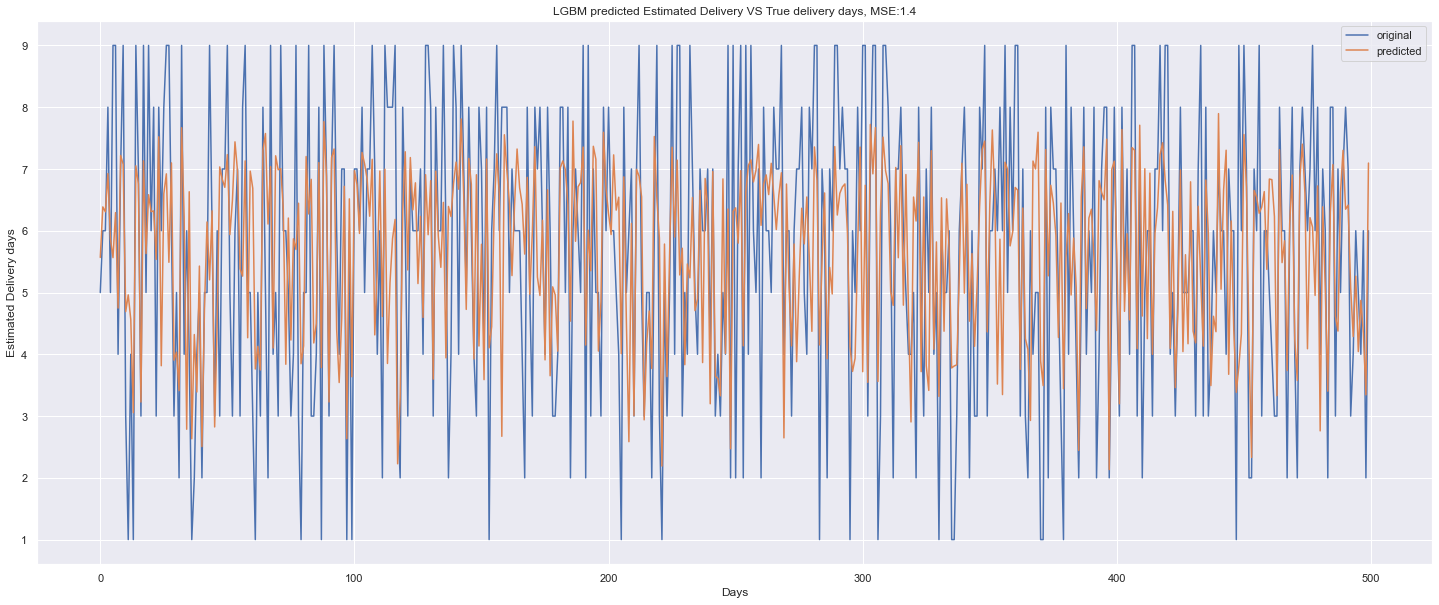

In [52]:
# Plots the first 500 predicted results and compares it to the original test values
x_ax = range(len(y_test[:500]))
plt.figure(figsize=(25, 10))
plt.plot(x_ax,y_test[:500], label="original")
plt.plot(x_ax,pred_test[:500], label="predicted")
plt.title("LGBM predicted Estimated Delivery VS True delivery days, MSE:"+str(lgbm_error)[0:3])
plt.xlabel('Days')
plt.ylabel('Estimated Delivery days')
plt.legend()
plt.show()

# RNN

In [70]:
def build_model( n1, n2, n3, n4, n5,n6):
    '''
    Creates a five layers Dense model following inputs parameters
    
    :param data_shape: Shape of the model input training data
    :param n1: Number of neurons on the first layer
    :param n2: Number of neurons on the second layer
    :param n3: Number of neurons on the third layer
    :param n4: Number of neurons on the fourth layer
    :param n5: Number of neurons on the final layer
    
    :returns: Sequential model
    
    '''

    model = models.Sequential()
    model.add(BatchNormalization())
    model.add(layers.Dense(units=n1, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(layers.Dense(units=n2, activation='relu'))
    model.add(Dropout(0.3))
    model.add(layers.Dense(units=n3, activation='relu'))
    model.add(layers.Dense(units=n4, activation='relu'))
    model.add(layers.Dense(units=n5, activation='relu'))
    model.add(layers.Dense(units=n6, activation='linear'))
    

    return model

In [71]:
#define neurons numbers
n1 = 1024
n2 = 512
n3 = 256
n4 = 64
n5 = 32
n6 = 1

#data_shape = X_train.shape

model = build_model( n1, n2, n3, n4, n5,n6)

In [72]:
#model.summary()

In [73]:
# Set early stopping monitor so the model stops training when it won't improve anymore
esm = EarlyStopping(monitor = 'val_loss', patience = 30)

# Set the optimizer
sgd = keras.optimizers.SGD(learning_rate = 0.001, decay=1e-6)

In [74]:
#compile model with the parameter
model.compile(optimizer=sgd, loss='mse', metrics=['mae'])
#train model
history = model.fit(X_train,y_train, batch_size=1000, epochs=500, verbose=1, validation_data = (X_valid, y_valid), callbacks = [esm])

Epoch 1/500
34/34 [==============================] - 5s 111ms/step - loss: 9.1849 - mae: 2.4342 - val_loss: 32.4197 - val_mae: 5.2007
Epoch 2/500
34/34 [==============================] - 3s 100ms/step - loss: 5.3989 - mae: 1.9131 - val_loss: 29.3382 - val_mae: 4.8963
Epoch 3/500
34/34 [==============================] - 4s 127ms/step - loss: 5.0100 - mae: 1.8389 - val_loss: 25.6208 - val_mae: 4.5141
Epoch 4/500
34/34 [==============================] - 5s 149ms/step - loss: 4.8387 - mae: 1.8036 - val_loss: 22.0104 - val_mae: 4.1368
Epoch 5/500
34/34 [==============================] - 4s 109ms/step - loss: 4.7340 - mae: 1.7813 - val_loss: 18.7723 - val_mae: 3.7687
Epoch 6/500
34/34 [==============================] - 4s 108ms/step - loss: 4.6429 - mae: 1.7657 - val_loss: 16.2424 - val_mae: 3.4784
Epoch 7/500
34/34 [==============================] - 4s 122ms/step - loss: 4.5771 - mae: 1.7528 - val_loss: 13.8130 - val_mae: 3.1818
Epoch 8/500
34/34 [==============================] - 4s 122ms/

34/34 [==============================] - 4s 121ms/step - loss: 3.9147 - mae: 1.6073 - val_loss: 5.3581 - val_mae: 1.8977
Epoch 63/500
34/34 [==============================] - 4s 110ms/step - loss: 3.9170 - mae: 1.6102 - val_loss: 5.1755 - val_mae: 1.8622
Epoch 64/500
34/34 [==============================] - 4s 107ms/step - loss: 3.9282 - mae: 1.6112 - val_loss: 5.2827 - val_mae: 1.8831
Epoch 65/500
34/34 [==============================] - 4s 104ms/step - loss: 3.9082 - mae: 1.6079 - val_loss: 5.2810 - val_mae: 1.8825
Epoch 66/500
34/34 [==============================] - 4s 121ms/step - loss: 3.8845 - mae: 1.5999 - val_loss: 5.3385 - val_mae: 1.8936
Epoch 67/500
34/34 [==============================] - 4s 116ms/step - loss: 3.9063 - mae: 1.6065 - val_loss: 5.3308 - val_mae: 1.8923
Epoch 68/500
34/34 [==============================] - 3s 104ms/step - loss: 3.9190 - mae: 1.6084 - val_loss: 5.3563 - val_mae: 1.8970
Epoch 69/500
34/34 [==============================] - 3s 103ms/step - loss:

34/34 [==============================] - 4s 115ms/step - loss: 3.7757 - mae: 1.5804 - val_loss: 5.2863 - val_mae: 1.8849
Epoch 124/500
34/34 [==============================] - 4s 106ms/step - loss: 3.7754 - mae: 1.5780 - val_loss: 5.1308 - val_mae: 1.8542
Epoch 125/500
34/34 [==============================] - 3s 100ms/step - loss: 3.7618 - mae: 1.5728 - val_loss: 5.0291 - val_mae: 1.8338
Epoch 126/500
34/34 [==============================] - 4s 124ms/step - loss: 3.7680 - mae: 1.5768 - val_loss: 5.0368 - val_mae: 1.8354
Epoch 127/500
34/34 [==============================] - 4s 119ms/step - loss: 3.7657 - mae: 1.5764 - val_loss: 4.8882 - val_mae: 1.8055
Epoch 128/500
34/34 [==============================] - 3s 101ms/step - loss: 3.7733 - mae: 1.5763 - val_loss: 5.0043 - val_mae: 1.8290
Epoch 129/500
34/34 [==============================] - 3s 95ms/step - loss: 3.7772 - mae: 1.5772 - val_loss: 5.1049 - val_mae: 1.8490
Epoch 130/500
34/34 [==============================] - 4s 120ms/step -

In [76]:
#predict y
y_pred = model.predict(X_test)

In [77]:
#calculate error
rnn_error = metrics.mean_absolute_error(y_test, y_pred)
rnn_error

1.8544192032491467

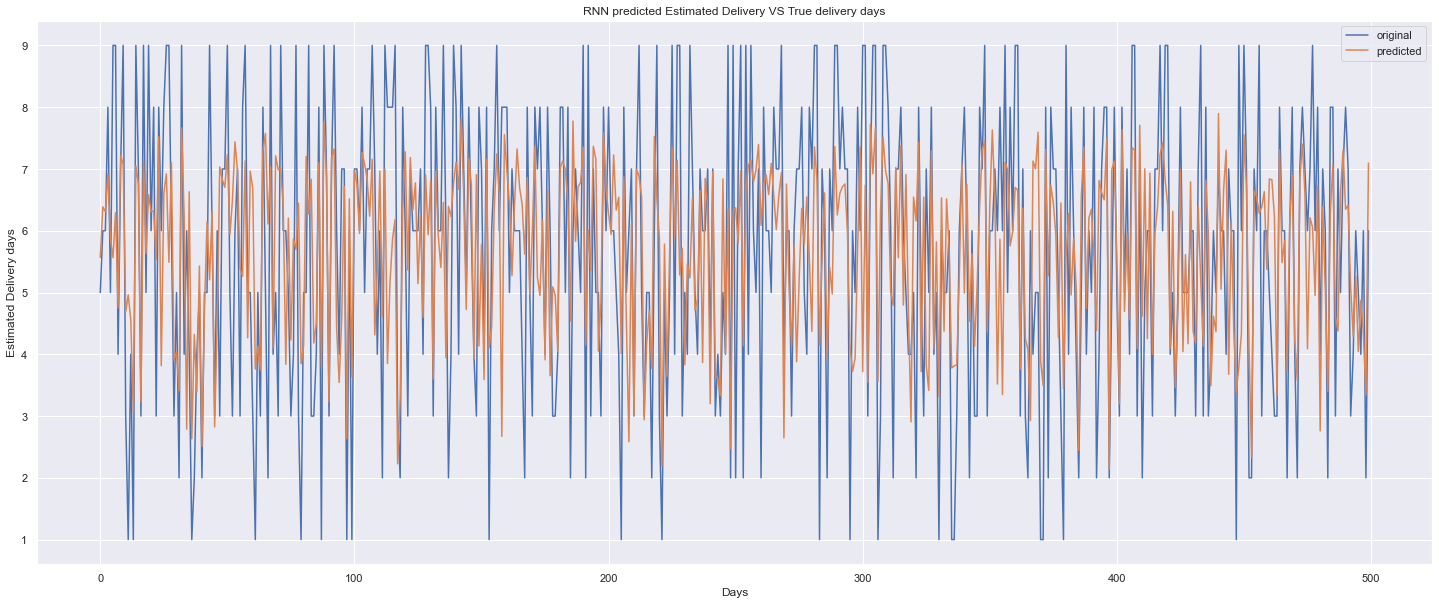

In [78]:
# Plots the first 500 predicted results and compares it to the original test values
x_ax = range(len(y_test[:500]))
plt.figure(figsize=(25, 10))
plt.plot(x_ax,y_test[:500], label="original")
plt.plot(x_ax,pred_test[:500], label="predicted")
plt.title("RNN predicted Estimated Delivery VS True delivery days")
plt.xlabel('Days')
plt.ylabel('Estimated Delivery days')
plt.legend()
plt.show()

# XGBOOST

In [79]:
XGB = XGBRegressor()
# Fit the model
XGB.fit(X_train, y_train)

# Predict
y_pred_train = XGB.predict(X_train)
y_pred_valid = XGB.predict(X_valid)

# Compute MSE
print("MAE train: ",metrics.mean_absolute_error(y_train, y_pred_train))
# Compute MSE
print("MAE valid: ",metrics.mean_absolute_error(y_valid, y_pred_valid))

MAE train:  1.1250107674538632
MAE valid:  1.4380903446069546


In [80]:
# Train the model
XGB = XGBRegressor()
XGB.fit(X_train, y_train)
pred_test = model.predict(X_test)
# Predict
xgb_error = metrics.mean_absolute_error(y_test, pred_test)
print("MAE test: ",metrics.mean_absolute_error(y_test, pred_test))


MAE test:  1.8544192032491467


# Model comparison

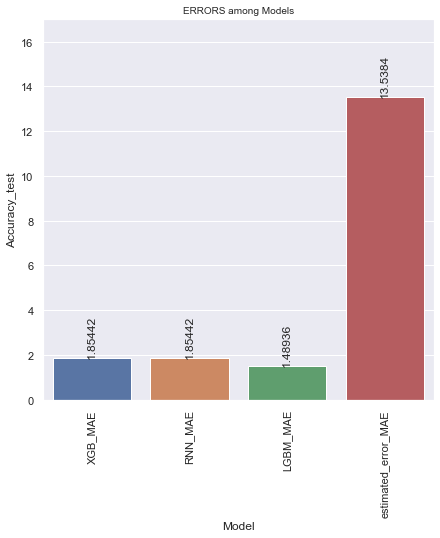

In [81]:
#define the plot
#set the dimension of the plot
Accuracy_list = [xgb_error,rnn_error,lgbm_error, estimated_error]

Model_list = ['XGB_MAE',"RNN_MAE",'LGBM_MAE', "estimated_error_MAE"]


graph = pd.DataFrame({'Model': Model_list, 'Accuracy_test' : Accuracy_list})
#graph = graph.sort_values('Accuracy_test', ascending=True)
sns.set(rc={'figure.figsize':(7,7)})

ax = sns.barplot(x= "Model",y="Accuracy_test", data=graph)

#attach the value of each bar
ax.bar_label(ax.containers[0], rotation = 90)

#rotate the label on X axis in order to allow to read each value
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylim((0,17))

#set the title of the plot
ax.set_title("ERRORS among Models", fontsize = 10)
plt.show()